### Initialization Cell

In [1]:
import matplotlib.pyplot as plt
import awkward as ak
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import numpy as np, pandas as pd

import UsefulFunction as uf

### User Defined Inputs

In [4]:
inputfiles = ["../Scintillator-Scanner/Aug26txt/1.txt"]  #list input files ,"../LongbarTiming/310002.txt","../LongbarTiming/320002.txt","../LongbarTiming/330002.txt","../LongbarTiming/340002.txt","../LongbarTiming/350002.txt","../LongbarTiming/360002.txt","../LongbarTiming/370002.txt"
outputfile = '../Examples/howtouse.txt'          #set output file location
filenumber = len(inputfiles)
channelnum = [1,2,3,4]             #list DRS4 board channels to record, ranges 1 to 4
verbose = True

rmscut = 1.5
timediffcut = 20

#choose which stats to analyze for each waveform
do_chi2 = 1
do_amplitude_raw = 0
do_amplitude_base = 1
do_amplitude_fit = 0
do_time_raw = 0
do_time_base = 1
do_time_fit = 0
do_time_CDF = 0
do_time_smooth = 0

#p0:C,start,m,end,A,d -- adjust start and end to match approx time of pulse falling edge
p0=[(0,60,1,70,100,-0.01),       #ch1 initial parameters
    (0,60,1,70,100,-0.01),       #ch2 initial parameters
    (0,75,1,85,100,-0.01),        #ch3 initial parameters
    (0,75,1,85,100,-0.01)]        #ch4 initial parameters
#chi2cut = 2
#Vcut = 20 #cut just above noise level, in (mV) 

channelnames=[]
for ch in channelnum:
    channelnames.append(f'ch{ch}')
#Add each stat to the dataframe
stats=[]
if do_chi2: stats.append("chisq")
if do_amplitude_raw: stats.append("P2P_raw")
if do_amplitude_base: stats.append("P2P_base")
if do_amplitude_fit: stats.append("P2P_fit")
if do_time_raw: stats.append("time_raw")
if do_time_base: stats.append("time_base")
if do_time_fit: stats.append("time_fit")
if do_time_CDF: stats.append("time_CDF")
if do_time_smooth: stats.append("time_smooth")

### Convert to P2P!

Event Number 1
Start Appending Lines
Channel 1 RMS: 10378.80; chi^2: 0.87; fit params: -1.96, 96.9, 46.15, 106.0, 1658.73, -0.013
Channel 2 RMS: 18377.37; chi^2: 5.22; fit params: -1.67, 98.1, 91.11, 105.6, 9602.88, -0.025
Channel 3 RMS: 21218.26; chi^2: 9.29; fit params: -0.80, 97.7, 78.55, 106.7, 8033.59, -0.022
Channel 4 RMS: 2632.82; chi^2: 2.43; fit params: -1.05, 97.2, 25.08, 105.6, 774.65, -0.012


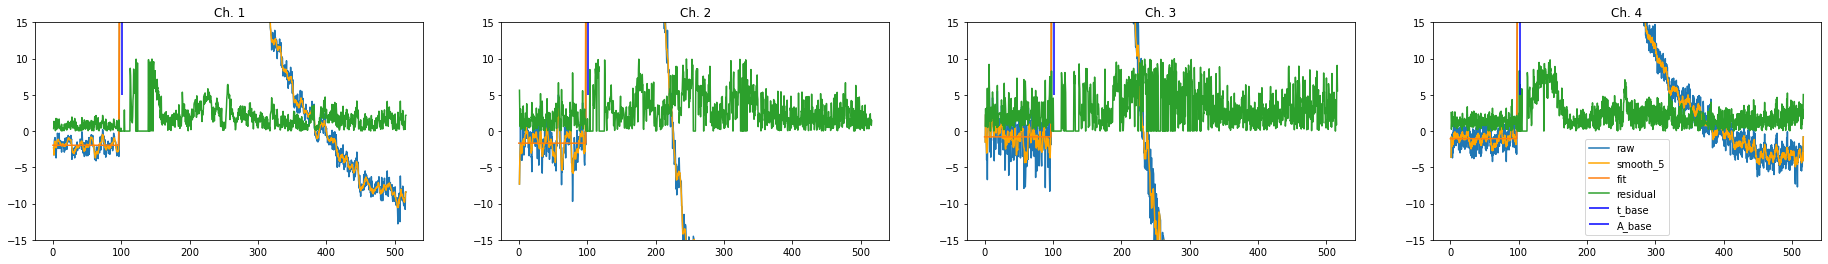

In [7]:
din = {a+"_"+b:[] for a in channelnames for b in stats}

with open(outputfile, 'w') as w:
    #w.write("")
    for i in range(0, filenumber):                             #iterate through files
        w.write(f"File {i}, Channel(s) {channelnum}, stats {stats}")
        with open(inputfiles[i]) as f:
            current_file = (f.read().split('-- Event'))
        
        for j in range(1, len(current_file)):                  #iterate through events len(current_file)
            #grab the data from each channel
            time = np.array([])
            voltage = [np.array([])]*4
            #print(current_file)
            lines = current_file[j].split('\n')
            #print(lines)
            if verbose and (j < 10): #show the waveform fit line
                print(f"Event Number {j}")
                fig,ax = plt.subplots(1,4,figsize=(32,4))
                ax[0].set_title("Ch. 1")
                ax[1].set_title("Ch. 2")
                ax[2].set_title("Ch. 3")
                ax[3].set_title("Ch. 4")
            print(f"Start Appending Lines")
            for line in lines[6:1028]:                         #iterate through data points
                values = line.split()
                time = np.append(time, float(values[2]))

                for channel in channelnum:
                    #if float(values[channel+2]) < Vcut: continue            #cut the false peaks from the DRS4 -- mismatches length of time list
                    voltage[channel-1] = np.append(voltage[channel-1], float(values[channel+2]))
            w.write('\n')
            
            #calculate stats for each channel
            for channel in channelnum:
                print(f"Event: {j}, Channel: {channel}",end="\r") #,end="\r"
                #only attempt a fit if it looks like there's not nothing
                totalrms = sum((voltage[channel-1]-np.mean(voltage[channel-1]))**2)/len(voltage[channel-1])
                if totalrms < rmscut:
                    popt = (np.mean(voltage[channel-1]),0,0,0,0,1)
                    
                    if do_chi2:
                        chisq = 0
                        din[f'ch{channel}_chisq'].append(chisq)
                        w.write(f"{chisq:.2f}\t")

                    #calculate amplitude
                    if do_amplitude_raw: 
                        amplitude = 0
                        din[f'ch{channel}_P2P_raw'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_base: 
                        amplitude = 0
                        din[f'ch{channel}_P2P_base'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_fit: 
                        amplitude = 0
                        din[f'ch{channel}_P2P_fit'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    #calculate time
                    if do_time_raw: 
                        pulse_time = 0
                        din[f'ch{channel}_time_raw'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")
                        
                    if do_time_base:
                        pulse_time = 0
                        din[f'ch{channel}_time_base'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_fit: 
                        pulse_time = 0
                        din[f'ch{channel}_time_fit'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")
                        
                    if do_time_smooth:
                        pulse_time = 0
                        din[f'ch{channel}_time_smooth'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                else:
                    popt, pcov = curve_fit(uf.waveform, time, voltage[channel-1],p0=p0[channel-1],
                                           maxfev = 100000)#,bounds=([-10,60,0,60,0,-1],[10,140,100,140,3000,0])
                    
                    fit_voltage = uf.waveform(time,*popt)
                    #remove "blips"
                    residual = np.abs(voltage[channel-1] - fit_voltage)
                    mask = residual < 10
                    for i, ele in enumerate(mask):
                        if ele == 0:# and np.abs(time[i] - get_time_fit(popt)) > 20:
                            voltage[channel-1][i] = uf.waveform(time[i],*popt)
                    residual = np.abs(voltage[channel-1] - fit_voltage)
                    
                    #calculate chi^2
                    if do_chi2:
                        chisq = uf.get_chi2(popt,time,voltage[channel-1])
                        din[f'ch{channel}_chisq'].append(chisq)
                        w.write(f"{chisq:.2f}\t")

                    #calculate amplitude
                    if do_amplitude_raw: 
                        amplitude = uf.get_amplitude_raw(voltage[channel-1])
                        din[f'ch{channel}_P2P_raw'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_base: 
                        amplitude = uf.get_amplitude_base(popt,voltage[channel-1])
                        din[f'ch{channel}_P2P_base'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_fit: 
                        amplitude = uf.get_amplitude_fit(popt)
                        din[f'ch{channel}_P2P_fit'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    #calculate time
                    if do_time_raw: 
                        pulse_time = uf.get_time_raw(time,voltage[channel-1])
                        din[f'ch{channel}_time_raw'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_base:
                        pulse_time = uf.get_time_base(popt, time, voltage[channel-1])
                        din[f'ch{channel}_time_base'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_fit: 
                        pulse_time = uf.get_time_fit(popt)
                        din[f'ch{channel}_time_fit'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")
                        
                    if do_time_smooth:
                        pulse_time = uf.get_time_smooth(popt, time, voltage[channel-1], 3)
                        din[f'ch{channel}_time_smooth'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")
                   
                if verbose and (j < 10): #show the waveform fit line
                    print(f"Channel {channel} RMS: {totalrms:.2f}; chi^2: {chisq:.2f}; fit params: {popt[0]:.2f}, {popt[1]:.1f}, {popt[2]:.2f}, {popt[3]:.1f}, {popt[4]:.2f}, {popt[5]:.3f}")
                    ts = np.linspace(0,200,201)
                    fits = uf.waveform(ts,*popt)
                    #for i in range(500):
                    #    xs.append(i)
                    #    ys.append(waveform(i,*popt))
                    ax[channel-1].plot(time,voltage[channel-1],label="raw")
                    ax[channel-1].plot(time,uf.voltage_smooth(voltage[channel-1],5),label="smooth_5", color='orange')
                    ax[channel-1].plot(ts,fits,label="fit")
                    ax[channel-1].plot(time,residual,label="residual")
                    #ax[channel-1].set_xlim(50,100)
                    ax[channel-1].set_ylim(-15,15)
                    #draw the P2P and time 
                    if do_time_raw: ax[channel-1].vlines(uf.get_time_raw(time,voltage[channel-1]),ymin=-10,ymax=20, color='r',label="t_raw")
                    if do_time_base: ax[channel-1].vlines(uf.get_time_base(popt,time,voltage[channel-1]),ymin=5,ymax=35, color='b',label="t_base")
                    if do_time_fit: ax[channel-1].vlines(uf.get_time_fit(popt),ymin=20,ymax=50, color='g',label="t_fit")
                    if do_amplitude_raw: ax[channel-1].hlines(uf.get_amplitude_raw(voltage[channel-1]),xmin=0,xmax=200, color='r',label="A_raw")
                    if do_amplitude_fit: ax[channel-1].hlines(uf.get_amplitude_fit(popt),xmin=0,xmax=200, color='g',label="A_fit")
                    if do_amplitude_base: ax[channel-1].hlines(uf.get_amplitude_base(popt,voltage[channel-1]),xmin=0,xmax=200, color='b',label="A_base")
                    if do_time_smooth: ax[channel-1].vlines(uf.get_time_smooth(popt,time,voltage[channel-1],5),ymin=35,ymax=65, color='orange',label="t_smooth_5")
                    
                  
            if verbose and (j < 10):
                plt.legend()        
                plt.show()
                
#print(f'Done!\nTotal events analyzed: {len(din["ch2_chisq"])}')
dfin = pd.DataFrame(din)

In [8]:
plt.scatter(dfcut.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfcut.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
plt.plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
plt.xlabel("SiPM_L Signal Time")
plt.ylabel("SiPM_R Signal Time")
plt.legend()
plt.show()

NameError: name 'dfcut' is not defined

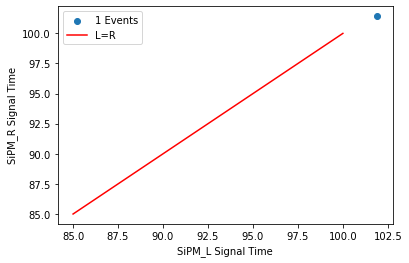

In [11]:
plt.scatter(dfin.query("ch3_P2P_base>10 & ch4_P2P_base>10").ch3_time_base,dfin.query("ch3_P2P_base>10 & ch4_P2P_base>10").ch4_time_base,label=f"{len(dfin.query('ch3_P2P_base>10 & ch4_P2P_base>10'))} Events")
plt.plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
plt.xlabel("SiPM_L Signal Time")
plt.ylabel("SiPM_R Signal Time")
plt.legend()
plt.show()

### How to read the output file into DataFrame:

In [ ]:
with open(outputfile) as f:  
    stats = []
    nchannelnames=[]
    nevents = (f.read().split('\n'))
    print(nevents[0].split('[')[2].split(']')[0].split("'"))
    nchannelnums = nevents[0].split('[')[1].split(']')[0].split(', ')
    for ch in nchannelnums:
        nchannelnames.append(f'ch{ch}')
    for i in range(len(nevents[0].split('[')[2].split(']')[0].split("'"))//2):
        stats.append(nevents[0].split('[')[2].split(']')[0].split("'")[2*i+1])

    dout = {a+"_"+b:[] for a in nchannelnames for b in stats}
    for event in nevents[:]:
        #print(f'Event: {event}')
        nvalues = event.split()
        if len(nvalues) != len(stats)*len(nchannelnames): continue
        for i in range(len(nchannelnames)):
            for j in range(len(stats)):
                dout[f'{nchannelnames[i]}_{stats[j]}'].append(float(nvalues[len(stats)*i+j]))
    #print(dout)
dfout = pd.DataFrame(dout)

In [ ]:
keys = ak.Array([[1],[],[2,3]])
print(keys)
ak.ArrayBuilder.append(keys[0],0)

In [ ]:
langs=["a lang","another lang","third lang"]

In [ ]:
for i in enumerate(langs):
    print(i)

In [ ]:
enums = enumerate(langs)
for n in enums:
    print(n)

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(10,5))

ax[0].scatter(dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"fit, {len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
ax[1].scatter(dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw,label=f"raw, {len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")
ax[0].plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
ax[0].set_xlabel("SiPM_L Signal Fit Time")
ax[0].set_ylabel("SiPM_R Signal Fit Time")
ax[1].plot(np.linspace(0,400,2),np.linspace(0,400,2),color="red",label="L=R")
ax[1].set_xlabel("SiPM_L Signal Raw Time")
ax[1].set_ylabel("SiPM_R Signal Raw Time")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit-dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,40, label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-20,10,50),gaus(np.linspace(-20,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.legend()
plt.show()

In [ ]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw-dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,900, label=f"{len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count,maxfev=10000000)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-10,10,50),gaus(np.linspace(-10,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.xlim(-20,20)
plt.legend()
plt.show()